In [2]:
import numpy as np
import h5py
from Bio import Phylo
from io import StringIO
import pandas as pd

In [3]:
species_id = pd.read_csv("species_id.csv", header=None, index_col=0)
species_id.columns = ["id"]
species_id.index.name = "species"

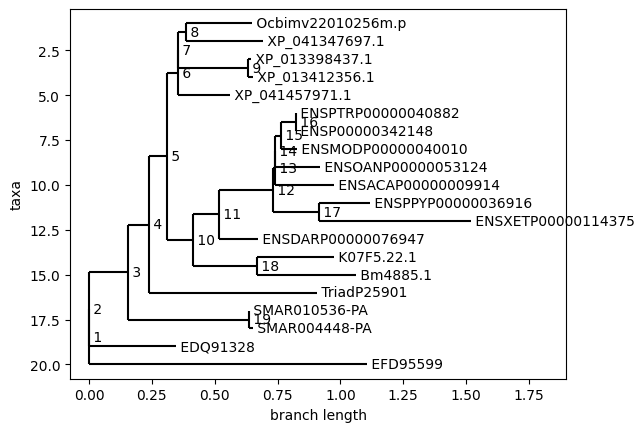

In [4]:
# Events and Species matrix
tree_str = "((((((((Ocbimv22010256m.p:0.26104[&&NHX:D=N:G=Ocbimv22010256m.g:T=37653],XP_041347697.1:0.305446[&&NHX:D=N:G=LOC121367533:T=1735272]):0.032711[&&NHX:D=N:B=0:T=6447],(XP_013398437.1:0.012456[&&NHX:D=N:G=LOC106164934:T=7574],XP_013412356.1:0.017599[&&NHX:D=N:G=LOC106175080:T=7574]):0.278993[&&NHX:D=Y:B=100:T=7574]):0[&&NHX:D=N:B=0:T=1206795],XP_041457971.1:0.207729[&&NHX:D=N:G=LOC121410147:T=7654]):0.046033[&&NHX:D=N:B=20:T=33213],(((((((ENSPTRP00000040882:0[&&NHX:D=N:G=ENSPTRG00000001040:T=9598],ENSP00000342148:0[&&NHX:D=N:G=ENSG00000215717:T=9606]):0.060272[&&NHX:D=N:B=100:T=207598],ENSMODP00000040010:0.067199[&&NHX:D=N:G=ENSMODG00000028749:T=13616]):0.020318[&&NHX:D=N:B=84:T=32525],ENSOANP00000053124:0.176689[&&NHX:D=N:G=ENSOANG00000042071:T=9258]):0.003495[&&NHX:D=N:B=73:T=40674],ENSACAP00000009914:0.237724[&&NHX:D=N:G=ENSACAG00000010122:T=28377]):0.008001[&&NHX:D=N:B=75:T=32524],(ENSPPYP00000036916:0.202782[&&NHX:D=N:G=ENSPPYG00000039113:T=9601],ENSXETP00000114375:0.60199[&&NHX:D=N:G=ENSXETG00000008004:T=8364]):0.186174[&&NHX:D=N:B=84:T=32523]):0.213378[&&NHX:DD=Y:B=37:T=32523],ENSDARP00000076947:0.155851[&&NHX:D=N:G=ENSDARG00000059400:T=7955]):0.101623[&&NHX:D=N:B=38:T=117571],(K07F5.22.1:0.308208[&&NHX:D=N:G=WBGene00303023:T=6239],Bm4885.1:0.393611[&&NHX:D=N:G=WBGene00225146:T=6279]):0.251722[&&NHX:D=N:B=94:T=6236]):0.106466[&&NHX:D=N:B=21:T=33213]):0.070302[&&NHX:DD=Y:B=8:T=33213],TriadP25901:0.66703[&&NHX:D=N:G=TriadG25901:T=10228]):0.084022[&&NHX:D=N:B=2:T=6072],(SMAR010536-PA:0.001149[&&NHX:D=N:G=SMAR010536:T=126957],SMAR004448-PA:0.014142[&&NHX:D=N:G=SMAR004448:T=126957]):0.482817[&&NHX:D=Y:B=100:T=126957]):0.154171[&&NHX:DD=Y:B=2:T=6072],EDQ91328:0.346481[&&NHX:D=N:G=MONBRDRAFT_14967:T=431895]):0[&&NHX:D=N:B=45:T=33154],EFD95599:1.1044[&&NHX:D=N:G=GL50803_34850:T=184922]):0[&&NHX:D=N:B=0:T=2759];"

event_nodes = []
event_columns = ["leaf", "duplication", "speciation"]
events = np.zeros((1, 3))
species_nodes = []
species = np.zeros((1, len(species_id))) # nodes
# adjacency matrix
# parent = species_id.index.to_list()
# child = species_id.index.to_list()

count = 1
tree = Phylo.read(StringIO(tree_str), "newick")
node = 0
root = True

for clade in tree.find_clades():
    if clade.name and ':[' in clade.name:
        name, nhx_string = clade.name.split(':[')
        nhx_tags = nhx_string.rstrip(']').split(':')
        nhx_data = {}
        for tag in nhx_tags:
            key, value = tag.split('=')
            nhx_data[key] = value
        clade.name = name
        clade.comment = str(nhx_data)

    # Event matrix
    if clade.name == None: # internal node
        node += 1
        clade.name = str(node)
        if "D=N" in clade.comment:
            event_nodes.append(clade.name)
            events = np.vstack([events, [0, 0, 1]])
        else:
            event_nodes.append(clade.name)
            events = np.vstack([events, [0, 1, 0]])
    else: # leaf node
        event_nodes.append(clade.name)
        events = np.vstack([events, [1, 0, 0]])

    # Species matrix
    if clade.name in species_id["id"].values:
        row = np.zeros(len(species_id))
        species_nodes.append(clade.name)
        species_name = species_id.loc[species_id["id"] == clade.name].index[0]
        row[species_id.index.to_list().index(species_name)] = 1
        species = np.vstack([species, row])

with h5py.File(f"event_{count}.h5", "w") as f:
    f.create_dataset("events", data=events)
    f.create_dataset("event_nodes", data=np.array(event_nodes, dtype='S'))
    f.create_dataset("event_columns", data=np.array(event_columns, dtype='S'))

with h5py.File(f"species_{count}.h5", "w") as f:
    f.create_dataset("species", data=species)
    f.create_dataset("species_nodes", data=np.array(species_nodes, dtype='S'))
    f.create_dataset("species_columns", data=np.array(species_id.index, dtype='S'))


Phylo.draw(tree)




In [5]:
parent = event_nodes.copy()
child = event_nodes.copy()
adjacency = np.zeros((len(parent), len(child)))

In [12]:
# Adjacency matrix

tree_str = "((((((((Ocbimv22010256m.p:0.26104[&&NHX:D=N:G=Ocbimv22010256m.g:T=37653],XP_041347697.1:0.305446[&&NHX:D=N:G=LOC121367533:T=1735272]):0.032711[&&NHX:D=N:B=0:T=6447],(XP_013398437.1:0.012456[&&NHX:D=N:G=LOC106164934:T=7574],XP_013412356.1:0.017599[&&NHX:D=N:G=LOC106175080:T=7574]):0.278993[&&NHX:D=Y:B=100:T=7574]):0[&&NHX:D=N:B=0:T=1206795],XP_041457971.1:0.207729[&&NHX:D=N:G=LOC121410147:T=7654]):0.046033[&&NHX:D=N:B=20:T=33213],(((((((ENSPTRP00000040882:0[&&NHX:D=N:G=ENSPTRG00000001040:T=9598],ENSP00000342148:0[&&NHX:D=N:G=ENSG00000215717:T=9606]):0.060272[&&NHX:D=N:B=100:T=207598],ENSMODP00000040010:0.067199[&&NHX:D=N:G=ENSMODG00000028749:T=13616]):0.020318[&&NHX:D=N:B=84:T=32525],ENSOANP00000053124:0.176689[&&NHX:D=N:G=ENSOANG00000042071:T=9258]):0.003495[&&NHX:D=N:B=73:T=40674],ENSACAP00000009914:0.237724[&&NHX:D=N:G=ENSACAG00000010122:T=28377]):0.008001[&&NHX:D=N:B=75:T=32524],(ENSPPYP00000036916:0.202782[&&NHX:D=N:G=ENSPPYG00000039113:T=9601],ENSXETP00000114375:0.60199[&&NHX:D=N:G=ENSXETG00000008004:T=8364]):0.186174[&&NHX:D=N:B=84:T=32523]):0.213378[&&NHX:DD=Y:B=37:T=32523],ENSDARP00000076947:0.155851[&&NHX:D=N:G=ENSDARG00000059400:T=7955]):0.101623[&&NHX:D=N:B=38:T=117571],(K07F5.22.1:0.308208[&&NHX:D=N:G=WBGene00303023:T=6239],Bm4885.1:0.393611[&&NHX:D=N:G=WBGene00225146:T=6279]):0.251722[&&NHX:D=N:B=94:T=6236]):0.106466[&&NHX:D=N:B=21:T=33213]):0.070302[&&NHX:DD=Y:B=8:T=33213],TriadP25901:0.66703[&&NHX:D=N:G=TriadG25901:T=10228]):0.084022[&&NHX:D=N:B=2:T=6072],(SMAR010536-PA:0.001149[&&NHX:D=N:G=SMAR010536:T=126957],SMAR004448-PA:0.014142[&&NHX:D=N:G=SMAR004448:T=126957]):0.482817[&&NHX:D=Y:B=100:T=126957]):0.154171[&&NHX:DD=Y:B=2:T=6072],EDQ91328:0.346481[&&NHX:D=N:G=MONBRDRAFT_14967:T=431895]):0[&&NHX:D=N:B=45:T=33154],EFD95599:1.1044[&&NHX:D=N:G=GL50803_34850:T=184922]):0[&&NHX:D=N:B=0:T=2759];"

event_nodes = []
event_columns = ["leaf", "duplication", "speciation"]
events = np.zeros((1, 3))
species_nodes = []
species = np.zeros((1, len(species_id))) # nodes
# adjacency matrix
# parent = species_id.index.to_list()
# child = species_id.index.to_list()

count = 1
tree = Phylo.read(StringIO(tree_str), "newick")
node = 0
root = True

for clade in tree.find_clades():
    if clade.name and ':[' in clade.name:
        name, nhx_string = clade.name.split(':[')
        nhx_tags = nhx_string.rstrip(']').split(':')
        nhx_data = {}
        for tag in nhx_tags:
            key, value = tag.split('=')
            nhx_data[key] = value
        clade.name = name
        clade.comment = str(nhx_data)

    # Adjacency matrix
    if clade.name != None:
        parent_node = clade.name
    if not root:
        adjacency[child.index(clade.name), parent.index(clade.name)] = 1
        root = False
        
with h5py.File(f"adjacency_{count}.h5", "w") as f:
    f.create_dataset("adjacency", data=adjacency)
    f.create_dataset("parent", data=np.array(parent, dtype='S'))
    f.create_dataset("child", data=np.array(child, dtype='S'))


In [18]:
# view files

import h5py
filename = "event_1.h5"

with h5py.File(filename, "r") as f:
    # Get the data
    events = np.array(f['events'])
    event_nodes = np.array(f['event_nodes'])
    event_columns = np.array(f['event_columns'])

print(events)
print(event_nodes)
print(event_columns)

[[0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
[b'1' b'2' b'3' b'4' b'5' b'6' b'7' b'8' b'Ocbimv22010256m.p'
 b'XP_041347697.1' b'9' b'XP_013398437.1' b'XP_013412356.1'
 b'XP_041457971.1' b'10' b'11' b'12' b'13' b'14' b'15' b'16'
 b'ENSPTRP00000040882' b'ENSP00000342148' b'ENSMODP00000040010'
 b'ENSOANP00000053124' b'ENSACAP00000009914' b'17' b'ENSPPYP00000036916'
 b'ENSXETP00000114375' b'ENSDARP00000076947' b'18' b'K07F5.22.1'
 b'Bm4885.1' b'TriadP25901' b'19' b'SMAR010536-PA' b'SMAR004448-PA'
 b'EDQ91328' b'EFD95599']


AttributeError: 'numpy.ndarray' object has no attribute 'str'

In [14]:

filename = "species_1.h5"

with h5py.File(filename, "r") as f:
    species = np.array(f['species'])
    species_nodes = np.array(f['species_nodes'])

print(species)
print(species_nodes)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[b'Ocbimv22010256m.p' b'XP_041347697.1' b'XP_013398437.1'
 b'XP_013412356.1' b'XP_041457971.1' b'ENSPTRP00000040882'
 b'ENSP00000342148' b'ENSMODP00000040010' b'ENSOANP00000053124'
 b'ENSACAP00000009914' b'ENSPPYP00000036916' b'ENSXETP00000114375'
 b'ENSDARP00000076947' b'K07F5.22.1' b'Bm4885.1' b'TriadP25901'
 b'SMAR010536-PA' b'SMAR004448-PA' b'EDQ91328' b'EFD95599']


In [16]:
filename = "adjacency_1.h5"

with h5py.File(filename, "r") as f:
    # Get the data
    adjacency = np.array(f['adjacency'])
    parent = np.array(f['parent'])
    child = np.array(f['child'])

print(adjacency)
print(parent)
print(child)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[b'1' b'2' b'3' b'4' b'5' b'6' b'7' b'8' b'Ocbimv22010256m.p'
 b'XP_041347697.1' b'9' b'XP_013398437.1' b'XP_013412356.1'
 b'XP_041457971.1' b'10' b'11' b'12' b'13' b'14' b'15' b'16'
 b'ENSPTRP00000040882' b'ENSP00000342148' b'ENSMODP00000040010'
 b'ENSOANP00000053124' b'ENSACAP00000009914' b'17' b'ENSPPYP00000036916'
 b'ENSXETP00000114375' b'ENSDARP00000076947' b'18' b'K07F5.22.1'
 b'Bm4885.1' b'TriadP25901' b'19' b'SMAR010536-PA' b'SMAR004448-PA'
 b'EDQ91328' b'EFD95599']
[b'1' b'2' b'3' b'4' b'5' b'6' b'7' b'8' b'Ocbimv22010256m.p'
 b'XP_041347697.1' b'9' b'XP_013398437.1' b'XP_013412356.1'
 b'XP_041457971.1' b'10' b'11' b'12' b'13' b'14' b'15' b'16'
 b'ENSPTRP00000040882' b'ENSP00000342148' b'ENSMODP00000040010'
 b'ENSOANP00000053124' b'ENSACAP00000009914' b'17' b'ENSPPYP00000036916'
 b'ENSXETP00000114375' b'ENSDARP00000076947' 